# Homework 4 - CSCI 7000
## Behzod Mirpochoev

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import expon
from scipy.stats import linregress

### Problem 1

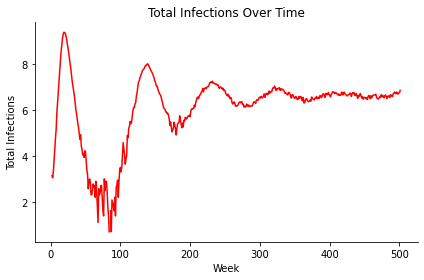

In [2]:
all_weeks = pd.read_csv('all_weeks.csv')
all_weeks.iloc[:, 1] *= 10

gamma = 1/2

total_weeks = all_weeks.shape[0]  
total_infections = np.zeros(total_weeks)

for index, row in all_weeks.iterrows():
    week = row['Week']
    new_cases = row['New Cases']
    
    lengths = expon.rvs(scale=1/gamma, size=int(new_cases))
    
    for length in lengths:
        end_week = min(total_weeks, week + int(length))
        total_infections[week:end_week] += 1

total_infections[np.where(total_infections == 0)] = np.nan
plt.plot(all_weeks['Week'], np.log(total_infections), color = 'red')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Total Infections Over Time')
plt.xlabel('Week')
plt.ylabel('Total Infections')

plt.tight_layout()
plt.savefig('1a_1.jpg', dpi = 300)

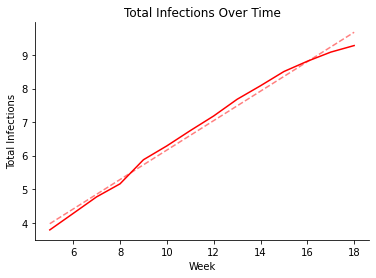

In [3]:
linear_regression = linregress(all_weeks['Week'][4:18], np.log(total_infections)[4:18])
linear_infections = linear_regression.slope * all_weeks['Week'][4:18] + linear_regression.intercept

plt.plot(all_weeks['Week'][4:18], np.log(total_infections)[4:18], color = 'red')
plt.plot(all_weeks['Week'][4:18], linear_infections, color = 'red', linestyle = '--', alpha = 0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Total Infections Over Time')
plt.xlabel('Week')
plt.ylabel('Total Infections')
plt.savefig('1a_2.jpg', dpi = 300)

In [4]:
left = linear_regression.slope - 1.96 * linear_regression.stderr
right = linear_regression.slope + 1.96 * linear_regression.stderr
R0 = 1 + linear_regression.slope / (gamma + 1/10)
print(f'R0 is {R0}')
print(f'95% confidence interval is [{1 + left / (gamma + 1/10)}, {1 + right / (gamma + 1/10)}]')

R0 is 1.73240107476614
95% confidence interval is [1.6919263992823153, 1.7728757502499648]


In [5]:
p_hat = 517/1000
left = p_hat + 1.96*np.sqrt( (p_hat)*(1 - p_hat) / 1000) 
right = p_hat - 1.96*np.sqrt( (p_hat)*(1 - p_hat) / 1000) 
R0 = 1 / (1 - p_hat)
print(f'Raw prevalence is {p_hat}')
print(f'R0 is {R0}')
print(f'95% CI is [{1 / (1-right)}, {1/ (1-left)}]')

Raw prevalence is 0.517
R0 is 2.070393374741201
95% CI is [1.945629752143622, 2.2122543130294745]


### Problem 3

In [6]:
pos_df = pd.read_csv("HW4_Q3_pos.csv")
neg_df = pd.read_csv("HW4_Q3_neg.csv")
data_df = pd.read_csv("HW4_Q3_data.csv")

neg_df.columns = ['values'] 
pos_df.columns = ['values']
data_df.columns = ['values'] 

neg_df['group'] = 'Negative Controls' 
pos_df['group'] = 'Positive Controls' 
data_df['group'] = 'Prevalence Study' 

all_data = pd.concat([neg_df, pos_df, data_df])

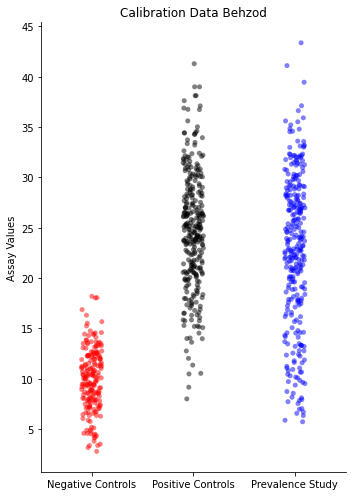

In [7]:
plt.figure(figsize=(5, 7))
palette_colors = {'Negative Controls': 'red', 'Positive Controls': 'black', 'Prevalence Study': 'blue'}

sns.stripplot(x='group', y='values', data = all_data, hue='group', palette=palette_colors, alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('')
plt.ylabel('Assay Values')
plt.legend().set_visible(False)
plt.title('Calibration Data Behzod')

plt.tight_layout()
plt.savefig('3a.jpg', dpi = 300)

In [8]:
def se(pos, c):
    return np.mean(pos > c)

def sp(neg, c):
    return np.mean(neg < c)

def phi_hat(empirical, c):
    return np.mean(empirical > c)

def theta_hat(pos, neg, empirical, se, sp, phi_hat, c):
    if se(pos, c) + sp(neg, c) == 1:
        return np.nan
    numer = phi_hat(empirical, c) - (1 - sp(neg, c))
    denom = se(pos, c) + sp(neg, c) - 1
    return numer / denom

In [9]:
pos = pos_df['values']
neg = neg_df['values']
field = data_df['values']

c_low = min(pos)
c_high = max(neg)

calibr = np.sort(pd.concat([neg_df, pos_df])['values'])
c_range = calibr[(calibr >= c_low) & (calibr <= c_high)]

J_opt, c_opt = max((se(pos, c) + sp(neg, c) - 1, c) for c in c_range)
print(f'Youden optimum = {J_opt}, c = {c_opt}')

Youden optimum = 0.9163207341053092, c = 15.082487812966695


Youden choice - TPR: 0.9565217391304348, FPR: 0.04020100502512558 (sp: 0.9597989949748744)


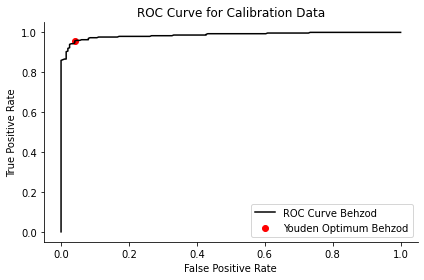

In [10]:
tpr = []
fpr = []
for c in calibr:
    tpr.append(se(pos, c))
    fpr.append(1 - sp(neg, c))

plt.plot(fpr, tpr, color='black', label='ROC Curve Behzod')
plt.scatter(1 - sp(neg, c_opt), se(pos, c_opt), color='red', label='Youden Optimum Behzod')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Calibration Data')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()

print(f'Youden choice - TPR: {se(pos, c_opt)}, FPR: {1 - sp(neg, c_opt)} (sp: {sp(neg, c_opt)})')

plt.tight_layout()
plt.savefig('3c_1.jpg', dpi = 300)

Youden choice - corrected prevalence = 0.8357543743809839, c = 15.082487812966695


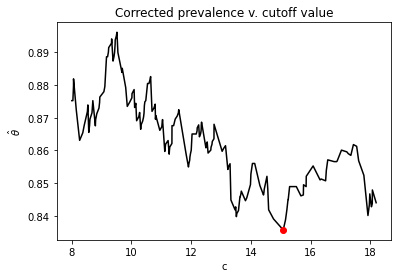

In [11]:
theta_vals = [theta_hat(pos, neg, field, se, sp, phi_hat, c) for c in c_range]
theta_opt = theta_hat(pos, neg, field, se, sp, phi_hat, c_opt)

plt.plot(c_range, theta_vals, color = 'black', zorder = 0)
plt.scatter(c_opt, theta_opt, color = 'red', zorder = 1)
plt.xlabel('c')
plt.ylabel(r'$\hat{\theta}$')
plt.title('Corrected prevalence v. cutoff value')

print(f'Youden choice - corrected prevalence = {theta_opt}, c = {c_opt}')

plt.savefig('3c_2a.jpg', dpi = 300)

Youden choice - corrected prevalence = 0.8357543743809839, c = 15.082487812966695


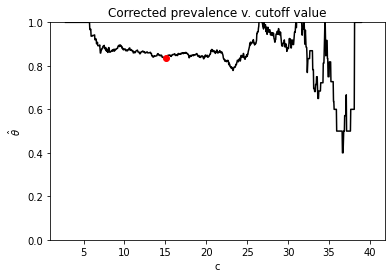

In [12]:
c_range_large = np.linspace(1,40, int(1e3))
theta_vals_large = [theta_hat(pos, neg, field, se, sp, phi_hat, c) for c in c_range_large]
theta_opt = theta_hat(pos, neg, field, se, sp, phi_hat, c_opt)

plt.plot(c_range_large, theta_vals_large, color = 'black', zorder = 0)
plt.scatter(c_opt, theta_opt, color = 'red', zorder = 1)
plt.xlabel('c')
plt.ylabel(r'$\hat{\theta}$')
plt.title('Corrected prevalence v. cutoff value')
plt.ylim(0,1)

print(f'Youden choice - corrected prevalence = {theta_opt}, c = {c_opt}')

plt.savefig('3c_2b.jpg', dpi = 300)